## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""


import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config)) 


Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2,0.5,0.8]
redice_lr_patient = [5,10,15]

In [8]:
import itertools

from keras.callbacks import ReduceLROnPlateau
    
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    """
# 載入 Callbacks, 並設定監控目標為 validation loss
"""

    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0730 07:53:23.875503  7332 deprecation_wrapper.py:119] From D:\InstalledTools\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 07:53:23.876506  7332 deprecation_wrapper.py:119] From D:\InstalledTools\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 07:53:23.887543  7332 deprecation_wrapper.py:119] From D:\InstalledTools\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 5


W0730 07:53:24.117307  7332 deprecation_wrapper.py:119] From D:\InstalledTools\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0730 07:53:24.540453  7332 deprecation_wrapper.py:119] From D:\InstalledTools\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0730 07:53:24.547476  7332 deprecation_wrapper.py:119] From D:\InstalledTools\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0730 07:53:24.687902  7332 deprecation.py:323] From D:\InstalledTools\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 2s 37us/step - loss: 1.5305 - acc: 0.4665 - val_loss: 1.6363 - val_acc: 0.4293
Epoch 14/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5141 - acc: 0.4724 - val_loss: 1.6272 - val_acc: 0.4306
Epoch 15/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4991 - acc: 0.4778 - val_loss: 1.6158 - val_acc: 0.4346
Epoch 16/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4830 - acc: 0.4819 - val_loss: 1.6057 - val_acc: 0.4368
Epoch 17/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4690 - acc: 0.4887 - val_loss: 1.6017 - val_acc: 0.4396
Epoch 18/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4550 - acc: 0.4927 - val_loss: 1.5906 - val_acc: 0.4400
Epoch 19/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.4422 - acc: 0.4978 - val_loss: 1.5839 - val_acc: 0.4469
Epoch 20/25
50000/50000 [=====================

50000/50000 [==============================] - 3s 56us/step - loss: 2.5140 - acc: 0.1953 - val_loss: 2.3838 - val_acc: 0.2436
Epoch 2/25
50000/50000 [==============================] - 2s 36us/step - loss: 2.0690 - acc: 0.3020 - val_loss: 2.0885 - val_acc: 0.3033
Epoch 3/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.9152 - acc: 0.3427 - val_loss: 1.9522 - val_acc: 0.3367
Epoch 4/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.8307 - acc: 0.3678 - val_loss: 1.8836 - val_acc: 0.3528
Epoch 5/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.7713 - acc: 0.3853 - val_loss: 1.8260 - val_acc: 0.3710
Epoch 6/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.7260 - acc: 0.4013 - val_loss: 1.7929 - val_acc: 0.3789
Epoch 7/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6888 - acc: 0.4126 - val_loss: 1.7606 - val_acc: 0.3889
Epoch 8/25
50000/50000 [============================

50000/50000 [==============================] - 2s 35us/step - loss: 1.3897 - acc: 0.5168 - val_loss: 1.5801 - val_acc: 0.4473
Epoch 25/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.3783 - acc: 0.5212 - val_loss: 1.5747 - val_acc: 0.4469
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.5564 - acc: 0.4552 - val_loss: 1.6558 - val_acc: 0.4242
Epoch 13/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5380 - acc: 0.4618 - val_loss: 1.6446 - val_acc: 0.4291
Epoch 14/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.5202 - acc: 0.4680 - val_loss: 1.6334 - val_acc: 0.4349
Epoch 15/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.5042 - acc: 0.4733 - val_loss: 1.6254 - val_acc: 0.4347
Epoch 16/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.4899 - acc: 0.4796 - val_loss: 1.6155 - val_acc: 0.4379
Epoch 17/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.4754 - acc: 0.4845 - val_loss: 1.6074 - val_acc: 0.4428
Epoch 18/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.4613 - acc: 0.4887 - val_loss: 1.6030 - val_acc: 0.4419
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.5197 - acc: 0.1923 - val_loss: 2.2819 - val_acc: 0.2667
Epoch 2/25
50000/50000 [==============================] - 2s 36us/step - loss: 2.0591 - acc: 0.2998 - val_loss: 2.1078 - val_acc: 0.3063
Epoch 3/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.9068 - acc: 0.3422 - val_loss: 1.9608 - val_acc: 0.3363
Epoch 4/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.8188 - acc: 0.3681 - val_loss: 1.8656 - val_acc: 0.3594
Epoch 5/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.7605 - acc: 0.3854 - val_loss: 1.8077 - val_acc: 0.3799
Epoch 6/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.7157 - acc: 0.4009 - val_loss: 1.7708 - val_acc: 0.3902
Epoch 7/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6800 - acc: 0.4119 - val_loss: 1.7446 - val_acc

50000/50000 [==============================] - 2s 39us/step - loss: 0.6711 - acc: 0.7860 - val_loss: 1.3581 - val_acc: 0.5390
Epoch 24/25
50000/50000 [==============================] - 2s 38us/step - loss: 0.6650 - acc: 0.7878 - val_loss: 1.3631 - val_acc: 0.5414

Epoch 00024: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 25/25
50000/50000 [==============================] - 2s 38us/step - loss: 0.6521 - acc: 0.7921 - val_loss: 1.3568 - val_acc: 0.5424
Numbers of exp: 10, reduce_factor: 0.20, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048  

50000/50000 [==============================] - 2s 38us/step - loss: 1.4919 - acc: 0.4805 - val_loss: 1.6295 - val_acc: 0.4329
Epoch 11/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4739 - acc: 0.4877 - val_loss: 1.6192 - val_acc: 0.4385
Epoch 12/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4582 - acc: 0.4938 - val_loss: 1.6062 - val_acc: 0.4386
Epoch 13/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4434 - acc: 0.4984 - val_loss: 1.6019 - val_acc: 0.4432
Epoch 14/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4301 - acc: 0.5033 - val_loss: 1.5939 - val_acc: 0.4457
Epoch 15/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4177 - acc: 0.5081 - val_loss: 1.5901 - val_acc: 0.4482
Epoch 16/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4050 - acc: 0.5136 - val_loss: 1.5851 - val_acc: 0.4480
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 87us/step - loss: 2.1705 - acc: 0.2816 - val_loss: 2.0529 - val_acc: 0.3302
Epoch 2/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.8126 - acc: 0.3745 - val_loss: 1.8740 - val_acc: 0.3639
Epoch 3/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.7143 - acc: 0.4039 - val_loss: 1.7998 - val_acc: 0.3849
Epoch 4/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6570 - acc: 0.4214 - val_loss: 1.7413 - val_acc: 0.3961
Epoch 5/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6139 - acc: 0.4382 - val_loss: 1.7128 - val_acc: 0.4050
Epoch 6/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.5813 - acc: 0.4487 - val_loss: 1.6895 - val_acc: 0.4136
Epoch 7/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.5536 - acc: 0.4585 - val_loss: 1.6696 - val_acc

50000/50000 [==============================] - 2s 38us/step - loss: 1.3037 - acc: 0.5525 - val_loss: 1.5474 - val_acc: 0.4556
Epoch 25/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2949 - acc: 0.5576 - val_loss: 1.5424 - val_acc: 0.4621
Numbers of exp: 15, reduce_factor: 0.80, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_46 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4509 - acc: 0.4961 - val_loss: 1.6000 - val_acc: 0.4400
Epoch 13/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4363 - acc: 0.5015 - val_loss: 1.5927 - val_acc: 0.4400
Epoch 14/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4210 - acc: 0.5079 - val_loss: 1.5882 - val_acc: 0.4439
Epoch 15/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4080 - acc: 0.5123 - val_loss: 1.5849 - val_acc: 0.4455
Epoch 16/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3956 - acc: 0.5172 - val_loss: 1.5756 - val_acc: 0.4487
Epoch 17/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3833 - acc: 0.5217 - val_loss: 1.5701 - val_acc: 0.4500
Epoch 18/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3737 - acc: 0.5254 - val_loss: 1.5641 - val_acc: 0.4549
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.8104 - acc: 0.3708 - val_loss: 2.4536 - val_acc: 0.2610
Epoch 2/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5394 - acc: 0.4548 - val_loss: 2.1819 - val_acc: 0.3052
Epoch 3/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4332 - acc: 0.4943 - val_loss: 3.4221 - val_acc: 0.1745
Epoch 4/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.3542 - acc: 0.5232 - val_loss: 2.2573 - val_acc: 0.3040
Epoch 5/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.2953 - acc: 0.5404 - val_loss: 2.2298 - val_acc: 0.2889
Epoch 6/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2438 - acc: 0.5620 - val_loss: 2.2804 - val_acc: 0.3079
Epoch 7/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.2032 - acc: 0.5738 - val_loss: 2.4159 - val_acc

50000/50000 [==============================] - 2s 38us/step - loss: 1.0359 - acc: 0.6544 - val_loss: 1.5123 - val_acc: 0.4710
Epoch 24/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.0183 - acc: 0.6613 - val_loss: 1.5058 - val_acc: 0.4744
Epoch 25/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.0007 - acc: 0.6675 - val_loss: 1.5160 - val_acc: 0.4851
Numbers of exp: 20, reduce_factor: 0.20, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_61 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_lay

Epoch 11/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2968 - acc: 0.5537 - val_loss: 1.5468 - val_acc: 0.4652
Epoch 12/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2700 - acc: 0.5632 - val_loss: 1.5245 - val_acc: 0.4705
Epoch 13/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2419 - acc: 0.5741 - val_loss: 1.5334 - val_acc: 0.4675
Epoch 14/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2189 - acc: 0.5831 - val_loss: 1.5274 - val_acc: 0.4745
Epoch 15/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.1949 - acc: 0.5917 - val_loss: 1.5298 - val_acc: 0.4733
Epoch 16/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.1706 - acc: 0.6031 - val_loss: 1.5281 - val_acc: 0.4756
Epoch 17/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.1504 - acc: 0.6114 - val_loss: 1.5225 - val_acc: 0.4784
Epoch 18/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 110us/step - loss: 2.3275 - acc: 0.2366 - val_loss: 2.1572 - val_acc: 0.2879
Epoch 2/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.9550 - acc: 0.3304 - val_loss: 1.9958 - val_acc: 0.3364
Epoch 3/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.8119 - acc: 0.3730 - val_loss: 1.8771 - val_acc: 0.3672
Epoch 4/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.7238 - acc: 0.3994 - val_loss: 1.8051 - val_acc: 0.3789
Epoch 5/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.6604 - acc: 0.4186 - val_loss: 1.7629 - val_acc: 0.3953
Epoch 6/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.6107 - acc: 0.4344 - val_loss: 1.7266 - val_acc: 0.4044
Epoch 7/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5676 - acc: 0.4520 - val_loss: 1.6804 - val_ac

50000/50000 [==============================] - 2s 37us/step - loss: 1.2128 - acc: 0.5863 - val_loss: 1.5353 - val_acc: 0.4636
Epoch 25/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.1987 - acc: 0.5913 - val_loss: 1.5248 - val_acc: 0.4697
Numbers of exp: 25, reduce_factor: 0.80, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_76 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizat

50000/50000 [==============================] - 2s 37us/step - loss: 1.4592 - acc: 0.4946 - val_loss: 1.6219 - val_acc: 0.4324
Epoch 12/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4354 - acc: 0.5031 - val_loss: 1.5988 - val_acc: 0.4408
Epoch 13/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4133 - acc: 0.5108 - val_loss: 1.5955 - val_acc: 0.4412
Epoch 14/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.3922 - acc: 0.5173 - val_loss: 1.5824 - val_acc: 0.4492
Epoch 15/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3710 - acc: 0.5269 - val_loss: 1.5792 - val_acc: 0.4486
Epoch 16/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.3520 - acc: 0.5335 - val_loss: 1.5601 - val_acc: 0.4563
Epoch 17/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.3329 - acc: 0.5413 - val_loss: 1.5774 - val_acc: 0.4475
Epoch 18/25
50000/50000 [=====================

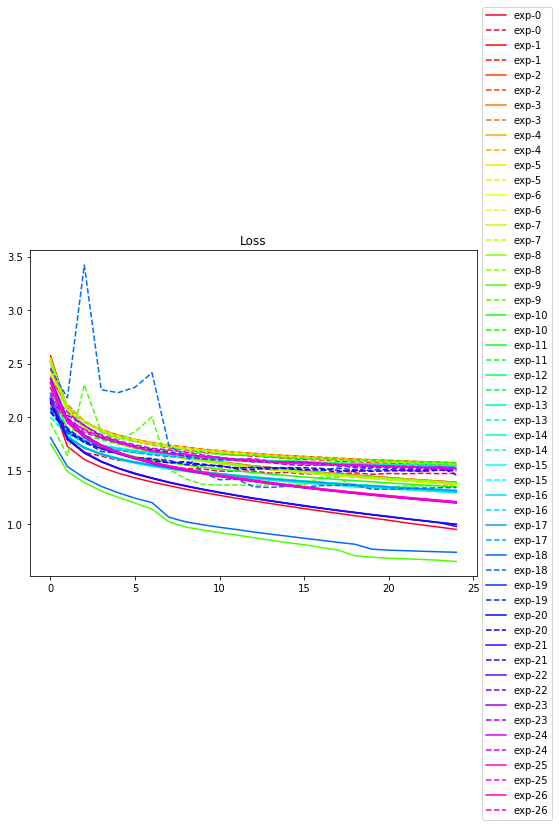

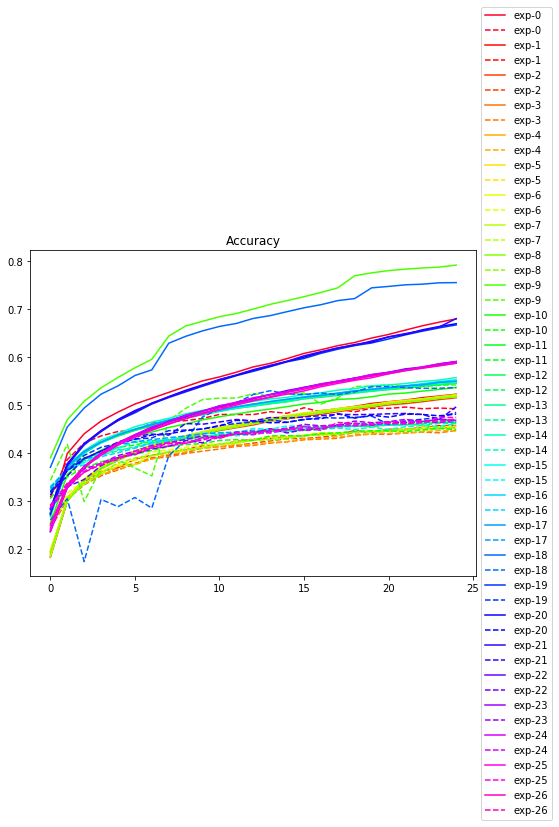

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()